In [3]:
import os
import netCDF4
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import time
import xarray as xr

In [4]:
def Get_NetCDFs(path):
    f = []
    for file in os.listdir(path):
        if file.endswith(".nc"):
            f.append(os.path.join(path, file)) 
#             print(os.path.join(path, file))
    return f

In [36]:
def DrawSIC(data,X,Y,date):   
    
    # 投影方式,npstere; 纬度，58~90; 0度经线，逆时针旋转315度
    m = Basemap(projection='npstere',boundinglat=75,lon_0=315,resolution='l') 
    fig = plt.figure(figsize=(8,8))
    x,y = m(X,Y)  # compute map proj coordinates
    
    # plot
    im = m.pcolormesh(x,y,data,cmap='gist_ncar',shading='flat',edgecolors='None')

    # 绘制海岸线
    m.drawcoastlines()
    # 填充陆地
    m.fillcontinents(color='silver',lake_color='aqua')
    # 绘制纬线
    para=m.drawparallels(np.arange(84,85),color='blue',fontsize=14,\
                    linewidth=3,latmax=84)
    # 绘制经线
    merid=m.drawmeridians(np.arange(-180.,181.,60.),latmax=84,fontsize=14)
    # 绘制边界线
    m.drawmapboundary(fill_color='aqua')  
    
    from matplotlib.font_manager import FontProperties 
    font1 = FontProperties(family='times new roman', size=24)
    font2 = FontProperties(family='times new roman', size=22)
    font3 = FontProperties(family='times new roman', size=22)
    # add colorbar    
    cbar = m.colorbar(location='bottom',\
                      spacing='uniform')
    cbar.set_label('Sea Ice Concentration (%)',fontproperties=font1)
    lim=np.arange(0,110,10)
    cbar.set_ticks(lim)
    cbar.ax.set_xticklabels(lim,fontproperties=font2)
    
    # 标注纬度
    lon=-150
    for lat in np.array([82]):
        x,y = m(lon, lat)
        plt.text(x,y,str(lat+2)[:2]+'°N',color='black',\
                 fontproperties=font3)
    # 标注经度
    lat=80
    for lon in np.arange(60,180,60):
        x,y = m(lon, lat)
        plt.text(x,y,str(lon)+'°E',color='black',\
                 fontproperties=font2)
    lat=77
    for lon in np.arange(-60,-180,-60):
        x,y = m(lon, lat)
        plt.text(x,y,str(-lon)+'°W',color='black',\
                 fontproperties=font2)    
    for lon in np.array([-178]):
        x,y = m(lon, lat)
        plt.text(x,y,str(-lon+2)+'°',color='black',\
                 fontproperties=font2)
                 
        
    import datetime as dt
    date=dt.datetime.strptime(date,'%Y%m%d')
    string = str(date.year)+'.'+str(date.month)+'.'+str(date.day)+' MERRA-2' 
    x0,y0=m(178,69)
    plt.text(x0,y0,string,color='black',\
                 fontproperties=font3)                
    
    plt.show()

In [5]:
os.getcwd()

'C:\\Users\\kathy\\research\\Sea-ice-concentration\\p_pro'

### 1. Read MERRA2 SIC

In [29]:
FilePath = "C:\\Users\\kathy\\research\\Sea-ice-concentration\\data\\MERRA2\\"

In [44]:
f = Get_NetCDFs(FilePath)
f[0]

'C:\\Users\\kathy\\research\\Sea-ice-concentration\\data\\MERRA2\\MERRA2_400.tavg1_2d_ocn_Nx.20161017.SUB.nc'

In [45]:
ds = xr.open_dataset(f[0])
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 41, lon: 540, time: 1)
Coordinates:
  * lat        (lat) float64 70.0 70.5 71.0 71.5 72.0 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.3 -178.7 -178.0 ... 178.0 178.7 179.3
  * time       (time) datetime64[ns] 2016-10-17T12:00:00
Dimensions without coordinates: bnds
Data variables:
    FRSEAICE   (time, lat, lon) float32 ...
    QV10M      (time, lat, lon) float32 ...
    T10M       (time, lat, lon) float32 ...
    U10M       (time, lat, lon) float32 ...
    V10M       (time, lat, lon) float32 ...
    time_bnds  (time, bnds) datetime64[ns] ...
Attributes:
    CDI:                               Climate Data Interface version 1.6.9 (...
    history:                           Mon Jan 27 22:03:56 2020: cdo -s -L -f...
    Conventions:                       CF-1
    History:                           Original file generated: Tue Nov  8 15...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
   

In [46]:
date = f[0][-15:-7]

In [47]:
sic = ds.FRSEAICE.values
lon = ds.lon.values
lat = ds.lat.values

In [48]:
sic = sic[0,:,:]
print(sic.min(),sic.max())

0.0 0.947214


### 2. Plot SIC Maps

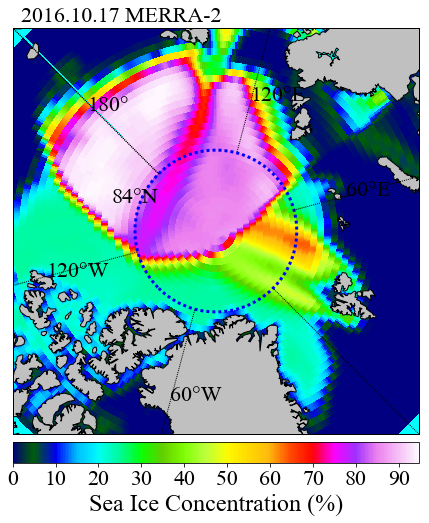

In [49]:
X,Y =np. meshgrid(lon,lat)
DrawSIC(sic*100,X,Y,date)

### 3. Calculate LCCA Index

In [69]:
lim2,lim1

28

In [26]:
def CountLow(data,pixel_area):
    ''' 统计低值出现频次 '''   
    """
    Input: data,冰密集度日数据; 
    Output: LCCA,低值面积/总面积  
    """ 

    ''' 统计研究范围总面积 —— 84N~90N '''
    a_total = np.sum(pixel_area)  
#     print('总面积：%f' %a_total)  #  显示总面积
    '''统计低值面积 —— sic小于75%且大于15%'''
    a_low = np.sum(pixel_area[data<0.75])-np.sum(pixel_area[data<0.15])
#     print('less than 0.15 %f' %np.sum(pixel_area[data<0.15]))
#     print('低值面积：%f' %a_low)  #  显示低值面积
    lcca = a_low/a_total*100 
    return lcca

In [15]:
def ReadSIC(dataset,low_lim,up_lim):
    
    lon = dataset.lon.values
    lat = dataset.lat.values
    sic = dataset.FRSEAICE.values
    sic = sic[0,low_lim:up_lim,:]     
    
    return sic,lat,lon

In [27]:
''' main 函数  '''
if __name__=="__main__":
    
    ds_1 = xr.open_dataset('C:\\Users\\kathy\\research\\Sea-ice-concentration\\data\\MERRA2\\Geodata\\merra2_gridarea_dot50.nc')
    cell_area = ds_1.cell_area.values

    lim1 = np.where(lat==88.5)[0][0]
    lim2 = np.where(lat==84.0)[0][0]

    cell_area = cell_area[lim2:lim1,:]

    Year = ['2016']
#     Year = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
    # '2005',
    #'2002','2003','2004',
    #'2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'] 
# '2008','2009',


    for i in range(len(Year)):
        
        
        FilePath = "D:\\MERRA2\\"+Year[i]+"\\" 
        FileName = Get_NetCDFs(FilePath)
        print(Year[i])
        
        
        file = open('MERRA2-SIC-LCCA-'+Year[i]+'-KD.txt','w')      
        for filename in FileName:
#             print(filename)
            ds = xr.open_dataset(filename)
            sic,lat,lon = ReadSIC(ds,lim2,lim1)
            
            date = filename[-15:-7]
            
            lcca = CountLow(sic,cell_area)
            print(date,lcca)
            
#             file.write('%10s %.2f' %(date,lcca))
#             file.write('\n')
        file.close()
        
    print('success')
    
    

2016
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160601 0.0
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160602 0.0
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160603 0.0
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160604 0.0
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160605 0.0
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160606 0.0
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160607 0.0
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160608 0.0
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160609 0.0
总面积：1396844764335.971680
less than 0.75 0.000000
less than 0.15 0.000000
低值面积：0.000000
20160610

In [17]:
filename

'D:\\MERRA2\\2005\\MERRA2_300.tavg1_2d_ocn_Nx.20050802.SUB.nc'